In [207]:
import nltk
import numpy as np
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import spacy
import re

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import tqdm


from keras.datasets import imdb

from string import punctuation

from collections import Counter

from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout,SpatialDropout1D, GRU, SimpleRNN
from keras.utils import to_categorical
from keras import layers

from keras.preprocessing.text import Tokenizer
from keras.initializers import Constant

from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import keras

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

from keras.layers import MaxPool1D, MaxPooling1D, Conv1D

from keras.layers.normalization import BatchNormalization
from gensim.models import Word2Vec

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import itertools

import logging 

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)




from sklearn.model_selection import train_test_split
import os

import pandas as pd
import matplotlib.pyplot as plt



nlp = spacy.load('en_core_web_sm')




In [122]:
# load data
def load_data(split_name='train', columns=['text', 'stars']):
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        df = df.loc[:,columns]
        print("succeed!")
        return df
    except:
        print("Failed, then try to ")
        print(f"select all columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        return df
    
#train_df = load_data('train', columns=['text'])
train_df = load_data('train', columns='full')
valid_df = load_data('valid', columns='full')

select [f, u, l, l] columns from the train split
Failed, then try to 
select all columns from the train split
select [f, u, l, l] columns from the valid split
Failed, then try to 
select all columns from the valid split


In [9]:
train_df.head()
print(train_df["cool"]+train_df["funny"])

0       0
1       0
2       0
3       0
4       2
       ..
9995    0
9996    2
9997    0
9998    0
9999    1
Length: 10000, dtype: int64


In [123]:
# pre-processing data
def nor_ds(dataset):    
    text = [re.sub("[^A-Za-z]+", ' ', str(line)).lower() for line in dataset]
    tokens = []    
    disable_list = [
                    "tagger",
                    "parser",
                    "ner",
                    "entity_linker",
                    "entity_ruler",
                    "textcat",
                    "textcat_multilabel",
                    "lemmatizer",
                    "morphologizer",
                    "sentencizer",                
                   ]
    for doc in nlp.pipe(text, n_process=4, batch_size=2000, disable=disable_list):        
        line_tokens = [token.text  for token in doc if not token.is_stop and len(token.text) > 1 ]
        if len(line_tokens) > 0:
            tokens.append(line_tokens)
        else:
            tokens.append(["neutral"])

    return tokens

def adj_ds(dataset):    
    text = [re.sub("[^A-Za-z]+", ' ', str(line)).lower() for line in dataset]
    tokens = []    
    disable_list = [
                    
                    "ner",
                    "entity_linker",
                    "entity_ruler",
                    "textcat",
                    "textcat_multilabel",
                    "lemmatizer",
                    "morphologizer",
                    "sentencizer",                
                   ]
    for doc in nlp.pipe(text, n_process=4, batch_size=2000, disable=disable_list):        
        line_tokens = [token.text  for token in doc if not token.is_stop and len(token.text) > 1 and token.pos_ in ["ADJ"]]
        if len(line_tokens) > 0:
            tokens.append(line_tokens)
        else:
            tokens.append(["neutral"])

    return tokens


# complete sentence layer
print("processing sentence data")
X_train = nor_ds(train_df["text"].values)
X_test  = nor_ds(valid_df["text"].values)
print("processing helpful data")
X_train_helpful = train_df["cool"] + train_df["funny"] + train_df["useful"]
X_test_helpful = valid_df["cool"] + valid_df["funny"] + valid_df["useful"]
print("processing adjective data")
X_train_adj = adj_ds(train_df["text"].values)
X_test_adj = adj_ds(valid_df["text"].values)

print(X_train)
print(X_test)
print(X_train_adj[:10])
print(X_test_adj[:10])

tokenizer = Tokenizer(split=' ')
total_reviews =  [" ".join(v) for v in X_train] + [" ".join(v) for v in X_test]
print(type(total_reviews),total_reviews[:3])

#tokenizer.fit_on_texts(total_reviews)
tokenizer.fit_on_texts(total_reviews)


#print("tokenizer_word_index",tokenizer.word_index)

max_length = max([len(s.split()) for s in total_reviews])
vocab_size = len(tokenizer.word_index) + 1
# X_train = tokenizer.texts_to_sequences(train_df['text'].values)
# X_train = pad_sequences(X_train)

X_train_tokens = tokenizer.texts_to_sequences(total_reviews)

X_test_tokens = tokenizer.texts_to_sequences(X_test)
print("X_train_tokens : ",X_train_tokens[:5])

#X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding="post")
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length)
#X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding="post")

'''
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding="post")


encoder = layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size)

X_train_vec = pd.Series([" ".join(v) for v in X_train]).astype(str)

X_train_dataset = pd.DataFrame(data={
    'text': pd.Series([" ".join(v) for v in X_train]).astype(str),
    'label': train_df["stars"]
})




#X_train_dataset = tf.data.Dataset.from_tensor_slices([(line[0],line[1]) for line in X_train_dataset])
X_train_dataset = tf.data.Dataset.from_tensor_slices((pd.Series([" ".join(v) for v in X_train]).astype(str),
                                                      to_categorical(train_df["stars"].values)))
print("X_train_dataset ",X_train_dataset.element_spec)
X_test_vec = pd.Series([" ".join(v) for v in X_test]).astype(str)
encoder.adapt(X_train_dataset.map(lambda text, label: text))
#encoder.adapt(X_test_vec.map(lambda text, label: text))
X_test_dataset =tf.data.Dataset.from_tensor_slices((pd.Series([" ".join(v) for v in X_test]).astype(str),
                                                      to_categorical(valid_df["stars"].values)))

BUFFER_SIZE = 10000
BATCH_SIZE = 64
X_train_dataset = X_train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
X_test_dataset = X_test_dataset.batch(BATCH_SIZE)


print("X_test_dataset ",X_test_dataset.element_spec)
'''


processing sentence data
processing helpful data
processing adjective data


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



X_train_tokens :  [[13, 1330, 1, 2, 4436, 41, 2, 195, 158], [80, 8, 145, 20, 153, 1273, 28, 58, 1585, 2008, 474, 747, 20, 153, 154, 650, 1980, 2878, 4232, 20, 573, 31, 40, 119, 76, 153, 86, 205, 40, 2, 32, 153, 646, 766, 198, 6, 4233, 15], [447, 222, 1384, 33, 1, 2, 166, 199, 2, 222, 1189, 1227, 30, 11, 5982, 2, 5328, 131, 467, 49], [560, 3, 1784, 549, 109, 7518, 3941, 3, 1, 7, 92, 413, 302, 92, 51, 497, 478], [1242, 1981, 62, 421, 1869, 6403, 373, 67, 3583, 2009, 485, 71]]


'\nX_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding="post")\n\n\nencoder = layers.experimental.preprocessing.TextVectorization(\n    max_tokens=vocab_size)\n\nX_train_vec = pd.Series([" ".join(v) for v in X_train]).astype(str)\n\nX_train_dataset = pd.DataFrame(data={\n    \'text\': pd.Series([" ".join(v) for v in X_train]).astype(str),\n    \'label\': train_df["stars"]\n})\n\n\n\n\n#X_train_dataset = tf.data.Dataset.from_tensor_slices([(line[0],line[1]) for line in X_train_dataset])\nX_train_dataset = tf.data.Dataset.from_tensor_slices((pd.Series([" ".join(v) for v in X_train]).astype(str),\n                                                      to_categorical(train_df["stars"].values)))\nprint("X_train_dataset ",X_train_dataset.element_spec)\nX_test_vec = pd.Series([" ".join(v) for v in X_test]).astype(str)\nencoder.adapt(X_train_dataset.map(lambda text, label: text))\n#encoder.adapt(X_test_vec.map(lambda text, label: text))\nX_test_dataset =tf.data.Dataset.from_ten

In [13]:
print(X_train_adj[:5])
print(X_train_tok)

[['nice', 'good', 'good'], ['meh', 'small', 'special', 'better', 'good'], ['good', 'good', 'best', 'schnitzel', 'good', 'busy'], ['phenomenal', 'pricey', 'great', 'attentive'], ['truffle', 'short', 'amazing']]


In [124]:
adj_tokenizer = Tokenizer(split=' ')
adj_lines = [" ".join(line) for line in X_train_adj] + [" ".join(line) for line in X_test_adj]
adj_tokenizer.fit_on_texts(adj_lines)
X_train_adj_tokens = adj_tokenizer.texts_to_sequences(adj_lines)

#X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding="post")
X_train_adj_pad = pad_sequences(X_train_adj_tokens, maxlen=max_length)
print(X_train_adj_pad)

[[   0    0    0 ...    3    1    1]
 [   0    0    0 ...   32    8    1]
 [   0    0    0 ... 1466    1   21]
 ...
 [   0    0    0 ...  425   71    6]
 [   0    0    0 ...   41    2   14]
 [   0    0    0 ...   30    3    1]]


In [125]:
# train dot2vec model

embedding_size=32


phrases = Phrases(X_train, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[X_train]

all_sentences = [v for v in sentences]

print(all_sentences[:20])
                     
# model_w2v = Word2Vec(vector_size=embedding_size, window=5, min_count=3, workers=4,                                        
#                     sample=6e-5, 
#                      alpha=0.03, 
#                      min_alpha=0.0007, 
#                      negative=20,)


model_w2v = Doc2Vec(dm=1, dm_concat=1, vector_size=embedding_size, window=5, negative=5, min_count=2, workers=4, alpha=0.065, min_alpha=0.065)
print("create taggedDocument")
document = [TaggedDocument(doc, [i]) for i, doc in enumerate(all_sentences)]
print("build vocab")
model_w2v.build_vocab(document, progress_per=10000)
print("training vocab")
model_w2v.train(document, total_examples=model_w2v.corpus_count, epochs=30, report_delay=1)
model_w2v.init_sims(replace=True)

#model_w2v = Word2Vec(sentences=common_texts, vector_size=embedding_size, window=5, min_count=1, workers=4)
model_w2v.wv.save_word2vec_format("word2vec_model.txt",binary=False)

print("vocab size :",model_w2v.wv.vectors.shape[0])

# read from word2vec model
embeddings_index ={}
f = open(os.path.join("", "word2vec_model.txt"), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size, embedding_size))

for word, i in tokenizer.word_index.items():
    if word in model_w2v.wv:
        embedding_matrix[i] = model_w2v.wv.get_vector(word)

print(embedding_matrix)

INFO - 14:11:28: collecting all words and their counts
INFO - 14:11:28: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 14:11:28: collected 392456 token types (unigram + bigrams) from a corpus of 531752 words and 10000 sentences
INFO - 14:11:28: merged Phrases<392456 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 14:11:28: Phrases lifecycle event {'msg': 'built Phrases<392456 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.62s', 'datetime': '2021-03-31T14:11:28.684038', 'gensim': '4.0.0', 'python': '3.7.3 (default, Apr 24 2020, 18:51:23) \n[Clang 11.0.3 (clang-1103.0.32.62)]', 'platform': 'Darwin-19.5.0-x86_64-i386-64bit', 'event': 'created'}
INFO - 14:11:28: exporting phrases from Phrases<392456 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 14:11:29: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<149 phrases, min_count=30, threshold=10.0> from Phrases<392456 vocab, min_count=30, threshol

[['nice', 'diner', 'food', 'good', 'comforting', 'definitely', 'good', 'spot', 'breakfast'], ['tried', 'got', 'fried_chicken', 'sandwich', 'meh', 'pretty', 'small', 'lacked', 'spices', 'flavors', 'expecting', 'chicken', 'sandwich', 'special', 'opinion', 'mary', 'browns', 'kfc', 'chicken', 'sandwiches', 'better', 'took', 'super', 'long', 'sandwich', 'store', 'pm', 'took', 'good', 'minutes', 'sandwich', 'combo', 'cashier', 'phone', 'time', 'updating', 'order'], ['expected', 'pork', 'selections', 'menu', 'food', 'good', 'beer_selection', 'good', 'pork_belly', 'app', 'best', 've', 'schnitzel', 'good', 'oddly', 'busy', 'friday_night'], ['yummy', 'place', 'phenomenal', 'pricey', 'feel', 'urge', 'splurge', 'place', 'food', 'great', 'server', 'attentive', 'yes', 'server', 'table', 'gets', 'servers'], ['truffle', 'macaroni', 'cheese', 'potatoes', 'au', 'gratin', 'short', 'amazing', 'death', 'row', 'choose', 'meal'], ['time', 'winking', 'lizard', 'area', 'enjoyed', 'bavarian', 'pretzels', 'sauce

INFO - 14:11:30: collecting all words and their counts
INFO - 14:11:30: PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO - 14:11:31: collected 26911 word types and 10000 unique tags from a corpus of 10000 examples and 520603 words
INFO - 14:11:31: Creating a fresh vocabulary
INFO - 14:11:31: Doc2Vec lifecycle event {'msg': 'effective_min_count=2 retains 15697 unique words (58.32930771803352%% of original 26911, drops 11214)', 'datetime': '2021-03-31T14:11:31.120258', 'gensim': '4.0.0', 'python': '3.7.3 (default, Apr 24 2020, 18:51:23) \n[Clang 11.0.3 (clang-1103.0.32.62)]', 'platform': 'Darwin-19.5.0-x86_64-i386-64bit', 'event': 'prepare_vocab'}
INFO - 14:11:31: Doc2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 509389 word corpus (97.84595939708376%% of original 520603, drops 11214)', 'datetime': '2021-03-31T14:11:31.120921', 'gensim': '4.0.0', 'python': '3.7.3 (default, Apr 24 2020, 18:51:23) \n[Clang 11.0.3 (clang-1103.0.32.62)]', 'platform': 'D

build vocab


INFO - 14:11:31: deleting the raw counts dictionary of 26911 items
INFO - 14:11:31: sample=0.001 downsamples 26 most-common words
INFO - 14:11:31: Doc2Vec lifecycle event {'msg': 'downsampling leaves estimated 489394.82028633525 word corpus (96.1%% of prior 509389)', 'datetime': '2021-03-31T14:11:31.221647', 'gensim': '4.0.0', 'python': '3.7.3 (default, Apr 24 2020, 18:51:23) \n[Clang 11.0.3 (clang-1103.0.32.62)]', 'platform': 'Darwin-19.5.0-x86_64-i386-64bit', 'event': 'prepare_vocab'}
INFO - 14:11:31: estimated required memory for 15697 words and 32 dimensions: 35239092 bytes
INFO - 14:11:31: resetting layer weights
INFO - 14:11:31: Doc2Vec lifecycle event {'msg': 'training model with 4 workers on 15698 vocabulary and 352 features, using sg=0 hs=0 sample=0.001 negative=5 window=5', 'datetime': '2021-03-31T14:11:31.394190', 'gensim': '4.0.0', 'python': '3.7.3 (default, Apr 24 2020, 18:51:23) \n[Clang 11.0.3 (clang-1103.0.32.62)]', 'platform': 'Darwin-19.5.0-x86_64-i386-64bit', 'event'

training vocab


INFO - 14:11:31: worker thread finished; awaiting finish of 3 more threads
INFO - 14:11:31: worker thread finished; awaiting finish of 2 more threads
INFO - 14:11:31: worker thread finished; awaiting finish of 1 more threads
INFO - 14:11:31: worker thread finished; awaiting finish of 0 more threads
INFO - 14:11:31: EPOCH - 1 : training on 520603 raw words (499239 effective words) took 0.4s, 1272510 effective words/s
INFO - 14:11:32: worker thread finished; awaiting finish of 3 more threads
INFO - 14:11:32: worker thread finished; awaiting finish of 2 more threads
INFO - 14:11:32: worker thread finished; awaiting finish of 1 more threads
INFO - 14:11:32: worker thread finished; awaiting finish of 0 more threads
INFO - 14:11:32: EPOCH - 2 : training on 520603 raw words (499402 effective words) took 0.4s, 1244814 effective words/s
INFO - 14:11:32: worker thread finished; awaiting finish of 3 more threads
INFO - 14:11:32: worker thread finished; awaiting finish of 2 more threads
INFO - 14:

INFO - 14:11:39: worker thread finished; awaiting finish of 0 more threads
INFO - 14:11:39: EPOCH - 20 : training on 520603 raw words (499502 effective words) took 0.4s, 1290527 effective words/s
INFO - 14:11:39: worker thread finished; awaiting finish of 3 more threads
INFO - 14:11:39: worker thread finished; awaiting finish of 2 more threads
INFO - 14:11:39: worker thread finished; awaiting finish of 1 more threads
INFO - 14:11:39: worker thread finished; awaiting finish of 0 more threads
INFO - 14:11:39: EPOCH - 21 : training on 520603 raw words (499483 effective words) took 0.4s, 1341822 effective words/s
INFO - 14:11:40: worker thread finished; awaiting finish of 3 more threads
INFO - 14:11:40: worker thread finished; awaiting finish of 2 more threads
INFO - 14:11:40: worker thread finished; awaiting finish of 1 more threads
INFO - 14:11:40: worker thread finished; awaiting finish of 0 more threads
INFO - 14:11:40: EPOCH - 22 : training on 520603 raw words (499375 effective words)

vocab size : 15698
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-3.68459535  1.37444925  0.6841166  ...  1.48991668 -1.68408406
  -0.36244282]
 [ 1.09229255 -0.22801112 -0.3626335  ... -0.74420321 -3.32613134
  -4.09105444]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [126]:
# train dot2vec model for adjective words

phrases = Phrases(X_train_adj, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
adjectives = bigram[X_train_adj]

all_adjectives = [v for v in adjectives]

print(all_adjectives[:20])
                     
# model_w2v = Word2Vec(vector_size=embedding_size, window=5, min_count=3, workers=4,                                        
#                     sample=6e-5, 
#                      alpha=0.03, 
#                      min_alpha=0.0007, 
#                      negative=20,)


model_w2v_adj = Doc2Vec(dm=1, dm_concat=1, vector_size=embedding_size, window=5, negative=5, min_count=2, workers=4, alpha=0.065, min_alpha=0.065)
print("create taggedDocument")
document = [TaggedDocument(doc, [i]) for i, doc in enumerate(all_adjectives)]
print("build vocab")
model_w2v_adj.build_vocab(document, progress_per=10000)
print("training vocab")
model_w2v_adj.train(document, total_examples=model_w2v_adj.corpus_count, epochs=30, report_delay=1)
model_w2v_adj.init_sims(replace=True)

#model_w2v = Word2Vec(sentences=common_texts, vector_size=embedding_size, window=5, min_count=1, workers=4)
model_w2v_adj.wv.save_word2vec_format("adj_word2vec_model.txt",binary=False)

print("vocab adj size :",model_w2v_adj.wv.vectors.shape[0])

# read from word2vec model
adj_embeddings_index ={}
f = open(os.path.join("", "adj_word2vec_model.txt"), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    adj_embeddings_index[word] = coefs
f.close()

adj_embedding_matrix = np.zeros((vocab_size, embedding_size))

for word, i in adj_tokenizer.word_index.items():
    if word in model_w2v_adj.wv:
        adj_embedding_matrix[i] = model_w2v_adj.wv.get_vector(word)

print(adj_embedding_matrix)

INFO - 14:11:51: collecting all words and their counts
INFO - 14:11:51: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 14:11:51: collected 59397 token types (unigram + bigrams) from a corpus of 94198 words and 10000 sentences
INFO - 14:11:51: merged Phrases<59397 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 14:11:51: Phrases lifecycle event {'msg': 'built Phrases<59397 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.11s', 'datetime': '2021-03-31T14:11:51.383582', 'gensim': '4.0.0', 'python': '3.7.3 (default, Apr 24 2020, 18:51:23) \n[Clang 11.0.3 (clang-1103.0.32.62)]', 'platform': 'Darwin-19.5.0-x86_64-i386-64bit', 'event': 'created'}
INFO - 14:11:51: exporting phrases from Phrases<59397 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 14:11:51: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<0 phrases, min_count=30, threshold=10.0> from Phrases<59397 vocab, min_count=30, threshold=10.0, 

[['nice', 'good', 'good'], ['meh', 'small', 'special', 'better', 'good'], ['good', 'good', 'best', 'schnitzel', 'good', 'busy'], ['phenomenal', 'pricey', 'great', 'attentive'], ['truffle', 'short', 'amazing'], ['bavarian', 'pleased', 'fun'], ['little', 'larger', 'polite', 'lovely', 'green'], ['great', 'garlic', 'great', 'baked', 'mixed', 'little', 'cooked', 'second', 'good', 'excellent', 'conscientious', 'excellent', 'nice'], ['antique', 'cute', 'awesome', 'best', 'vintage', 'worth'], ['sure', 'delicious', 'decadent', 'concerned', 'dirty', 'perfect', 'good', 'sized', 'yummy', 'huge', 'short', 'dirty', 'delicious', 'classic', 'cheap'], ['tasty', 'smaller', 'great', 'manchego', 'slow', 'great', 'creative', 'funky', 'cool', 'warm', 'romantic', 'older', 'good', 'crazy', 'nice'], ['mad', 'neat', 'little', 'csi', 'csi', 'cool', 'laughable', 'crappiest', 'low', 'obvious', 'awesome', 'old', 'mad', 'craptastic'], ['better', 'good', 'asian', 'gracious', 'pleasant', 'eager', 'peach', 'refreshing'

INFO - 14:11:51: worker thread finished; awaiting finish of 3 more threads
INFO - 14:11:51: worker thread finished; awaiting finish of 2 more threads
INFO - 14:11:51: worker thread finished; awaiting finish of 1 more threads
INFO - 14:11:51: worker thread finished; awaiting finish of 0 more threads
INFO - 14:11:51: EPOCH - 1 : training on 94198 raw words (77724 effective words) took 0.2s, 334508 effective words/s
INFO - 14:11:52: worker thread finished; awaiting finish of 3 more threads
INFO - 14:11:52: worker thread finished; awaiting finish of 2 more threads
INFO - 14:11:52: worker thread finished; awaiting finish of 1 more threads
INFO - 14:11:52: worker thread finished; awaiting finish of 0 more threads
INFO - 14:11:52: EPOCH - 2 : training on 94198 raw words (77808 effective words) took 0.2s, 334701 effective words/s
INFO - 14:11:52: worker thread finished; awaiting finish of 3 more threads
INFO - 14:11:52: worker thread finished; awaiting finish of 2 more threads
INFO - 14:11:52:

INFO - 14:11:56: EPOCH - 20 : training on 94198 raw words (77630 effective words) took 0.2s, 317909 effective words/s
INFO - 14:11:56: worker thread finished; awaiting finish of 3 more threads
INFO - 14:11:56: worker thread finished; awaiting finish of 2 more threads
INFO - 14:11:56: worker thread finished; awaiting finish of 1 more threads
INFO - 14:11:56: worker thread finished; awaiting finish of 0 more threads
INFO - 14:11:56: EPOCH - 21 : training on 94198 raw words (77878 effective words) took 0.2s, 337069 effective words/s
INFO - 14:11:57: worker thread finished; awaiting finish of 3 more threads
INFO - 14:11:57: worker thread finished; awaiting finish of 2 more threads
INFO - 14:11:57: worker thread finished; awaiting finish of 1 more threads
INFO - 14:11:57: worker thread finished; awaiting finish of 0 more threads
INFO - 14:11:57: EPOCH - 22 : training on 94198 raw words (77701 effective words) took 0.2s, 328638 effective words/s
INFO - 14:11:57: worker thread finished; await

vocab adj size : 2809
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.72450471  0.29725319 -0.06057299 ... -0.43816075 -0.25987327
   0.33079097]
 [ 0.17616732  0.54496789 -0.28987563 ... -0.33969417 -0.50784272
  -0.05899191]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [127]:
# model input layers
# complete sentence layer (pre-trained by Dot2Vec model), Shape=(vocab_size, embedding_size)
# helpful information layer (cool, funny, useful), Shape = (3, training_datasize)
# adjective words layer (POS == ADJ), shape = (vocab_size, embedding_size)

X_train_helpful = np.hstack((np.vstack(train_df["cool"]) , np.vstack(train_df["funny"]) ,np.vstack(train_df["useful"])))
X_test_helpful = np.hstack((np.vstack(valid_df["cool"]), np.vstack(valid_df["funny"]), np.vstack(valid_df["useful"])))
print(X_train_helpful[:10])
print(X_test_helpful[:10])
X_combine_helpful = np.vstack((X_train_helpful,X_test_helpful))
print(X_combine_helpful[:10])
print(X_combine_helpful.shape)


[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [0 0 1]
 [0 0 0]
 [0 0 0]
 [0 1 0]]
[[0 0 0]
 [0 0 0]
 [0 2 1]
 [1 1 0]
 [0 0 0]
 [0 0 3]
 [0 0 0]
 [0 0 0]
 [5 0 3]
 [0 0 1]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [0 0 1]
 [0 0 0]
 [0 0 0]
 [0 1 0]]
(12000, 3)


In [216]:
# train model

VOCAB_SIZE = vocab_size
EMBEDDING_SIZE = embedding_size

# Use Input layers, specify input shape (dimensions except first)
input_length = max_length
#layer_sentence_data = keras.layers.Input(shape=(VOCAB_SIZE, EMBEDDING_SIZE))
inp_sentence_data = keras.layers.Input(shape=(input_length,),name="inp_sentence")
inp_adj_data = keras.layers.Input(shape=(input_length,), name="inp_adj")


#inp_helpful_data = keras.layers.Input(shape=(input_length,))

layer_sentence_data = Embedding( vocab_size, 
                                 embedding_size,
                                 weights=[embedding_matrix],
                                 input_length=max_length,
                                 trainable=False)(inp_sentence_data)
layer_adj_data =  Embedding( vocab_size, 
                                 embedding_size,
                                 weights=[adj_embedding_matrix],
                                 input_length=max_length,
                                 trainable=False)(inp_adj_data)

#layer_helpful_data = keras.layers.Input(shape=(input_length,32),name="inp_helpful")


# Bind nulti_hot to embedding layer
#emb = keras.layers.Embedding(input_dim=no_of_unique_cat, output_dim=embedding_size)(inp_cat_data)  

# rnn_sentence = Conv1D(64, kernel_size=3,kernel_initializer='random_normal',
#     bias_initializer='zeros')(layer_sentence_data)

# rnn_adj = Conv1D(64, kernel_size=3,kernel_initializer='random_normal',
#     bias_initializer='zeros')(layer_adj_data)

rnn_sentence = layers.Bidirectional(GRU(units=32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,kernel_initializer='random_normal',
    bias_initializer='zeros'))(layer_sentence_data)

rnn_adj = layers.Bidirectional(GRU(units=32, dropout=0.2, recurrent_dropout=0.2,return_sequences=True, kernel_initializer='random_normal',
    bias_initializer='zeros'))(layer_adj_data)



input_layers = layers.concatenate([rnn_sentence, rnn_adj])

#mlp = layers.Conv1D(64, kernel_size=3, padding='valid', activation='relu', kernel_initializer='random_normal',
#    bias_initializer='zeros' )(input_layers)
#mlp = layers.Conv1D(64, kernel_size=3, padding='valid', activation='relu')(mlp)
#mlp = layers.MaxPooling1D(pool_size=8)(mlp)

# mlp = layers.Flatten()(mlp)
# mlp = layers.Dense(20, activation = "relu")(mlp)
# mlp = tf.expand_dims(mlp, axis=-1)
mlp = layers.Bidirectional(GRU(units=64,kernel_initializer='random_normal',
    bias_initializer='zeros'))(input_layers)
#mlp = layers.Flatten()(mlp)
mlp = Dense(64,activation='relu')(mlp)
mlp = BatchNormalization()(mlp)
mlp = Dropout(0.5)(mlp)
#mlp = layers.Flatten()(mlp)
output_layers = keras.layers.Dense(5, activation="softmax")(mlp)

model = keras.Model(name="MLP_Dot2Vec_CNN_RNN",inputs=[inp_sentence_data, inp_adj_data], outputs=output_layers)
model.summary()


'''
model=Sequential()

#embeddings_initializer=Constant(embedding_matrix),

model.add(Embedding(vocab_size, 
                    embedding_size,
                     weights=[embedding_matrix],
                    input_length=max_length,
                   trainable=False))

#model.add(layers.Bidirectional(GRU(units=64, dropout=0.2, return_sequences=True)))
model.add(Conv1D(128, kernel_size=3, padding='valid', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=8))

model.add(layers.Bidirectional(GRU(units=64, dropout=0.2)))



model.add(Dense(64,activation='relu'))

model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))
'''


#model.add(BatchNormalization())
#model.add(BatchNormalization())
#model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu'))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
#model.add(layers.Dropout(0.5))


#model.add(layers.Bidirectional(LSTM(embedding_size//2, dropout=0.2, recurrent_dropout=0.2)))
#model.add(SpatialDropout1D(0.4))
#model.add(SpatialDropout1D(0.4))

# compile
model.compile(loss='categorical_crossentropy', 
            optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

# train
batch_size = 256
num_epochs = 7

#X_train, X_test, Y_train, Y_test = train_test_split(X_train_pad,to_categorical(train_df["stars"].values), test_size = 0.33, random_state = 42)
#print(X_train.shape,Y_train.shape)
#print(X_test.shape,Y_test.shape)

#Y_train = np.array(to_categorical(train_df["stars"].values))
#Y_test = np.array(to_categorical(valid_df["stars"].values))


sentiment = np.concatenate((train_df["stars"].values, valid_df["stars"].values)) - 1
isWithInRange = True
print(type(sentiment[0]), sentiment[0])
for num in sentiment:
    if num < 1 or num > 5:
        isWithInRange = False
        print("outlier : ",num)
        break
        
        
VALIDATION_SPLIT = 0.2
indices = np.arange(X_train_pad.shape[0])
np.random.shuffle(indices)
#shuffle_train_pad = X_train_pad
#shuffle_train_pad = np.array(X_train_helpful) + np.array(X_test_helpful)
#shuffle_train_pad = np.array((X_train_pad), X_train_adj_pad,X_combine_helpful)

print("shuffle_train_pad : ",len(shuffle_train_pad), len(X_train_helpful), len(X_test_helpful),shuffle_train_pad[:5])

#shuffle_train_pad = X_train_pad[indices]
#sentiment = sentiment[indices]
num_validation_samples = int(VALIDATION_SPLIT * X_train_pad.shape[0])

sentiment = np.array(to_categorical(sentiment))
print(sentiment[:3])

# X_train_pad = shuffle_train_pad[:-num_validation_samples]
# Y_train = sentiment[:-num_validation_samples]
# X_test_pad = shuffle_train_pad[-num_validation_samples:]
# Y_test = sentiment[-num_validation_samples:]

print("X_train_len : ",len(shuffle_train_pad))
#X_train_pad_tmp = shuffle_train_pad[:10000]
X_train_pad_tmp = [X_train_pad[:10000], X_train_adj_pad[:10000]]
Y_train_tmp = sentiment[:10000]
X_test_pad_tmp = [X_train_pad[10000:], X_train_adj_pad[10000:]]
Y_test_tmp = sentiment[10000:]


#print("shape of X_train_pad : ",X_train_pad_tmp.shape)
print("shape of Y_train : ",Y_train_tmp.shape)
#print("shape of X_test_pad : ",X_test_pad_tmp.shape)
print("shape of Y_test  : ",Y_test_tmp.shape)


print(model.summary())


callback = EarlyStopping(monitor='val_accuracy', mode="max",baseline=0.025,patience=10)

#print(X_test_pad)
#print(X_train[0])
print("test pad : ",len(X_test_pad_tmp))
print("start training")
#X_train = np.array([" ".join(v) for v in X_train])
#model.fit(X_train_pad, Y_train, epochs = num_epochs, batch_size=batch_size, validation_data=(X_test_pad, Y_test), callbacks=[callback])
#            validation_steps=,
history = model.fit(  X_train_pad_tmp, Y_train_tmp, 
            epochs=100,
                    batch_size=batch_size,
            validation_data=(X_test_pad_tmp,Y_test_tmp), 

          verbose=1,
            callbacks=[callback]              
         )
# X_valid, Y_valid = X_train[:batch_size], Y_train[:batch_size]
# X_train2, Y_train2 = X_train[batch_size:], Y_train[batch_size:]
# history = model.fit(X_train2, Y_train2, validation_data=(X_valid, Y_valid), batch_size=batch_size, epochs=num_epochs)
print(model.summary())
# predict
print(history)


validation_size = 1500

# test_loss, test_acc = model.evaluate(X_test_dataset)

# print('Test Loss: {}'.format(test_loss))
# print('Test Accuracy: {}'.format(test_acc))

#X_validate = X_test_pad_tmp[-validation_size:]
#Y_validate = Y_test_tmp[-validation_size:]


#X_validate = X_test_pad_tmp[-validation_size:]
X_validate = [X_train_pad[12000-validation_size:], X_train_adj_pad[12000-validation_size:]]
Y_validate = Y_test_tmp[-validation_size:]




#Y_test = np.array(to_categorical(X_["stars"].values))

#X_test = X_test_pad

score,acc = model.evaluate(X_validate, Y_validate, verbose = 1, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))
# plt.figure(figsize=(16,8))
# plt.subplot(1,2,1)
# plot_graphs(history, 'accuracy')
# plt.ylim(None,1)
# plt.subplot(1,2,2)
# plot_graphs(history, 'loss')
# plt.ylim(0,None)
# scores = model.evaluate(X_test, y_test, verbose=0)
# print('Test accuracy:', scores[1])

Model: "MLP_Dot2Vec_CNN_RNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_sentence (InputLayer)       [(None, 506)]        0                                            
__________________________________________________________________________________________________
inp_adj (InputLayer)            [(None, 506)]        0                                            
__________________________________________________________________________________________________
embedding_197 (Embedding)       (None, 506, 32)      932608      inp_sentence[0][0]               
__________________________________________________________________________________________________
embedding_198 (Embedding)       (None, 506, 32)      932608      inp_adj[0][0]                    
________________________________________________________________________________

40/40 [==============================] - 106s 3s/step - loss: 1.0230 - accuracy: 0.5736 - val_loss: 0.9720 - val_accuracy: 0.5895
Epoch 15/100
40/40 [==============================] - 107s 3s/step - loss: 1.0173 - accuracy: 0.5683 - val_loss: 0.9889 - val_accuracy: 0.5845
Epoch 16/100
40/40 [==============================] - 114s 3s/step - loss: 1.0195 - accuracy: 0.5711 - val_loss: 1.1640 - val_accuracy: 0.5150
Epoch 17/100
40/40 [==============================] - 131s 3s/step - loss: 1.0087 - accuracy: 0.5778 - val_loss: 0.9976 - val_accuracy: 0.5700
Epoch 18/100
40/40 [==============================] - 129s 3s/step - loss: 0.9957 - accuracy: 0.5804 - val_loss: 0.9691 - val_accuracy: 0.5820
Epoch 19/100
40/40 [==============================] - 120s 3s/step - loss: 0.9936 - accuracy: 0.5827 - val_loss: 1.0372 - val_accuracy: 0.5530
Epoch 20/100
40/40 [==============================] - 137s 3s/step - loss: 0.9863 - accuracy: 0.5892 - val_loss: 0.9730 - val_accuracy: 0.5855
Epoch 21/100

KeyboardInterrupt: 

In [ ]:
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [87]:
print(train_df.head())
X_train_helpful = np.hstack((np.vstack(train_df["cool"]) , np.vstack(train_df["funny"]) ,np.vstack(train_df["useful"])))
X_test_helpful = np.hstack((np.vstack(valid_df["cool"]), np.vstack(valid_df["funny"]), np.vstack(valid_df["useful"])))
print(X_train_helpful[:10])
print(X_test_helpful[:10])
X_combine_helpful = np.vstack((X_train_helpful,X_test_helpful))
print(X_combine_helpful[:10])

              business_id  cool                 date  funny  \
0  39rLHYJOy2774ZIUouuWLw     0  2017-06-28 21:44:02      0   
1  E-Kq1Yu1d6N3TL2qX0aqjA     0  2018-04-09 03:45:19      0   
2  nWW6fBfBljiRFa4sG7TyxA     0  2014-07-19 02:00:04      0   
3  qmIHO-6T_KEfPC9jyGDamQ     0  2011-11-11 08:10:24      0   
4  pKk7jCFIm96qDdk0laVT2w     1  2010-01-16 20:04:00      1   

                review_id  stars  \
0  ynzOFepQYSCDGdfWDWxiZw      4   
1  sQX9ncJBEdBf16AWsvO6Vg      2   
2  bVIf2kqbzvif3miNe3ARNw      4   
3  LNj1OFxy2ool3PZANGchPA      4   
4  bZXxa0hO6wQlHD-MkMf4iw      5   

                                                text  useful  \
0  Nice to have a diner still around. Food was go...       0   
1  Tried this a while back, got the fried chicken...       0   
2  I expected more pork selections on menu. Food ...       0   
3  YUMMY!!! This place is phenomenal. It is Price...       0   
4  The Truffle Macaroni & Cheese and Potatoes Au ...       1   

                  u

appending
ploting


/Library/Python/3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 0 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Python/3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 0 missing from current font.
  font.set_text(s, 0, flags=flags)


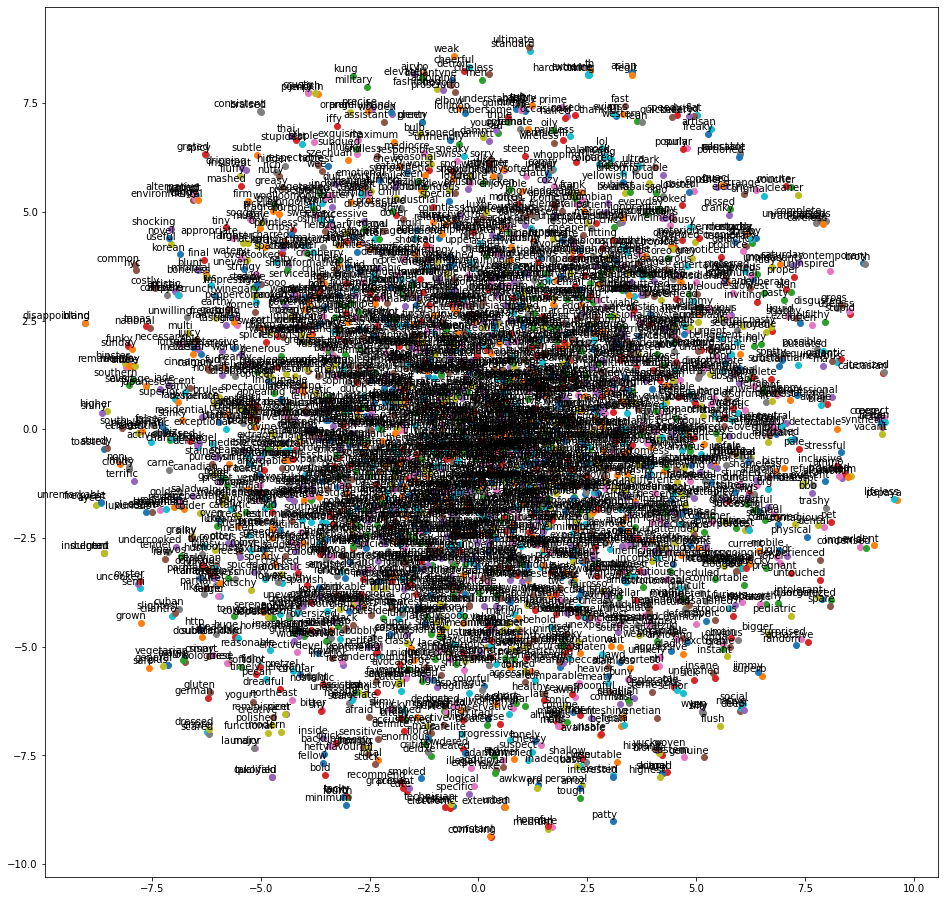

[('cashier', 0.7478154301643372),
 ('desk', 0.7154335379600525),
 ('mike', 0.7047698497772217),
 ('measuring', 0.6989907622337341),
 ('password', 0.6813330054283142),
 ('paved', 0.6708946824073792),
 ('directly', 0.6652189493179321),
 ('boss', 0.6632064580917358),
 ('philippines', 0.660541832447052),
 ('lady', 0.6585379242897034)]

In [209]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((321, 32), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    print(arrays.shape)
    print(arrays)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=30).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    
    
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
#    print( model.wv.key_to_index )
    for word in model.wv.key_to_index.keys():
        tokens.append(model.wv.get_vector(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    print("appending")
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    print("ploting")
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot(model_w2v_adj)
#tsnescatterplot(model_w2v, 'good', [i[0] for i in model_w2v.wv.most_similar(negative=["good"])])
model_w2v.wv.most_similar("manager")


In [218]:
model_w2v.wv.most_similar("good")



[('fantastic', 0.748343288898468),
 ('delicious', 0.7217516899108887),
 ('excellent', 0.6942803263664246),
 ('spectacular', 0.6849734783172607),
 ('fabulous', 0.6801556348800659),
 ('favourite', 0.6801526546478271),
 ('great', 0.6744253039360046),
 ('damn', 0.6675571203231812),
 ('amazing', 0.6616103649139404),
 ('pretty_good', 0.6610962152481079)]